Source
- Scraping Twitter: https://github.com/JustAnotherArchivist/snscrape/tree/master/snscrape
- SNScrape + Tweepy: https://medium.com/@jcldinco/downloading-historical-tweets-using-tweet-ids-via-snscrape-and-tweepy-5f4ecbf19032
- Tweet Preprocessing: https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing
- Sentiment Analysis: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082


## Bitcoin

In [118]:
from newsapi_help_func import *
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
from collections import Counter
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
# nltk.download
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
# !pip install ekphrasis
# !pip install tweet-preprocessor
import preprocessor as p

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import tweepy

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from string import punctuation

import spacy
from spacy import displacy
# Optional - download a language model for SpaCy
# !python -m spacy download en_core_web_sm
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

#For Sentiment Analysis
from textblob import TextBlob
from wordcloud import WordCloud
plt.style.use('fivethirtyeight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Cell below scrapes strictly using SNScrape and converts the json file to csv

In [41]:
!snscrape --max-results 2000 twitter-hashtag Bitcoin > bitcoin_2000.json

def json_to_csv(file_name):
    """
    Takes in json file and writes it into a csv file of the same name.
    """
    file_name = str(file_name)
    table = []
    with open((file_name+'.json'), 'r', encoding="utf8") as f:
        for line in f:
            table.append(json.loads(line))
    pd.DataFrame.from_records(table).to_csv(file_name+'.csv')

btc = json_to_csv('bitcoin_2000')

In [10]:
# snscrape --help
# usage: snscrape [-h] [--version] [-v] [--dump-locals] [--retry N] [-n N]
#                 [-f FORMAT] [--since DATETIME]
#                 {telegram-channel,vkontakte-user,googleplus-user,facebook-user,facebook-group,gab-user,gab-user-comments,gab-user-media,twitter-search,twitter-thread,twitter-list-members,instagram-user,instagram-hashtag,instagram-location,twitter-user,twitter-hashtag,twitter-list-posts}
#                 ...
# snscrape: error: argument scraper: invalid choice: 'twitter-hahtag' (choose from 'telegram-channel', 'vkontakte-user', 'googleplus-user', 'facebook-user', 'facebook-group', 'gab-user', 'gab-user-comments', 'gab-user-media', 'twitter-search', 'twitter-thread', 'twitter-list-members', 'instagram-user', 'instagram-hashtag', 'instagram-location', 'twitter-user', 'twitter-hashtag', 'twitter-list-posts')

# !snscrape twitter-search  "#Bitcoin since:2020-11-01 until: 2020-11-02 max: 100" > btc_tweets_daily.txt
# !snscrape --max-results 100 twitter-hashtag bitcoin "since: 2020-11-01 until: 2020-11-02"
# !snscrape -max-results 100 twitter-search "#Bitcoin since: 2020-11-01 until: 2020-11-02" > btc_tweets.txt
# !snscrape --max-results 100 --since 20201102 twitter-hashtag Bitcoin

!snscrape --max-results 100 --since 20201102 twitter-hashtag Bitcoin

usage: snscrape [-h] [--version] [-v] [--dump-locals] [--retry N] [-n N]
                [-f FORMAT] [--since DATETIME]
                {telegram-channel,vkontakte-user,googleplus-user,facebook-user,facebook-group,gab-user,gab-user-comments,gab-user-media,twitter-search,twitter-thread,twitter-list-members,instagram-user,instagram-hashtag,instagram-location,twitter-user,twitter-hashtag,twitter-list-posts}
                ...
snscrape: error: argument scraper: invalid choice: 'twitter-hahtag' (choose from 'telegram-channel', 'vkontakte-user', 'googleplus-user', 'facebook-user', 'facebook-group', 'gab-user', 'gab-user-comments', 'gab-user-media', 'twitter-search', 'twitter-thread', 'twitter-list-members', 'instagram-user', 'instagram-hashtag', 'instagram-location', 'twitter-user', 'twitter-hashtag', 'twitter-list-posts')


API Keys from Twitter Developer Account

In [11]:
consumer_key = "zB47sntXHX5qOLEkmuekKKlQd" 
consumer_secret = "IErfVGx6JiSgz2tTI5tVx4V5pB1Fofkj5yQIGihBnVt6JDWSd7" 
access_token = "AAAAAAAAAAAAAAAAAAAAAHykJQEAAAAAoJbCd66XTyca79rpkZEYU5yEFnE%3Dz3gcwG12uixSB2GYjhrR0YiyhquIkKvq1EbL0WTHtv93GBQEMX" 
# access_token_secret = "NNNNNNNNNNNNNNNNNNNNNNNNN"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
# auth.set_access_token(access_token, access_token_secret)
# auth.set_access_token(access_token)
api = tweepy.API(auth)

 Open .txt or .json using pandas.read_json or pandas.read_csv

In [4]:
tweet_url = pd.read_csv("bitcoin_tweets.txt", index_col= None, header = None, names = ["links"])
tweet_url.head()

links
0  https://twitter.com/JoaoDMendes/status/1322689...
1  https://twitter.com/Z06Z07/status/132268980142...
2  https://twitter.com/PoisonI96460421/status/132...
3  https://twitter.com/CryptoWatchBot/status/1322...
4  https://twitter.com/planethardmoney/status/132...

 Extract tweet_id using .split function

In [5]:
af = lambda x: x["links"].split("/")[-1]
tweet_url['id'] = tweet_url.apply(af, axis=1)
tweet_url.head()

links                   id
0  https://twitter.com/JoaoDMendes/status/1322689...  1322689810381840385
1  https://twitter.com/Z06Z07/status/132268980142...  1322689801422696450
2  https://twitter.com/PoisonI96460421/status/132...  1322689799975653376
3  https://twitter.com/CryptoWatchBot/status/1322...  1322689779755032577
4  https://twitter.com/planethardmoney/status/132...  1322689752978624513

Convert tweet_url Series into list

In [6]:
ids = tweet_url['id'].tolist()

Issue looping through all ids, the API is giving an error. Therefore, process the ids by batch or chunks

In [7]:
total_count = len(ids)
chunks = (total_count - 1) // 50 + 1

Create function that would extract all elements that we need from the tweet (username, date and the tweet). Add hashtags???

In [8]:
def fetch_tw(ids):
    list_of_tw_status = api.statuses_lookup(ids, tweet_mode= "extended")
    empty_data = pd.DataFrame()
    for status in list_of_tw_status:
            tweet_elem = {"tweet_id": status.id,
                     "screen_name": status.user.screen_name,
                     "tweet":status.full_text,
                     "date":status.created_at}
            empty_data = empty_data.append(tweet_elem, ignore_index = True)
    empty_data.to_csv("bitcoin_tweets.csv", mode="a")

Create another for loop to loop into our batches while processing 50 entries every loop. (That felt like a tongue twister)

In [54]:
for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
df_tweets = pd.read_csv('./data/btc_tweets.csv',
                 lineterminator='\n')

In [77]:
df_tweets.head()

Unnamed: 0                 date     screen_name  \
0         0.0  2020-10-31 23:58:52   Sarah85381260   
1         1.0  2020-10-31 23:59:40       TraderKoz   
2         2.0  2020-10-31 23:57:38     Solipsist18   
3         3.0  2020-10-31 23:58:01  Yayaya18948871   
4         4.0  2020-10-31 23:58:35      k_filippop   

                                               tweet                tweet_id  
0  Yworld Finance Airdrop is now Live🚀💰🏆\n\nClick...  1.3226895270187622e+18  
1  What are you doing when #Bitcoin makes a new ATH?  1.3226897280182272e+18  
2  #Bitcoin: BTC-USD ( $BTC-USD) UP 2.1721%! Last...  1.3226892163425935e+18  
3  Royal Defi Airdrop is now Live🚀💰🏆\n\nClick on ...  1.3226893124213391e+18  
4                             @BitcoinWhaIe #bitcoin   1.322689456642687e+18

In [13]:
df_tweets.count()

Unnamed: 0     14971
date           15270
screen_name    15270
tweet          15270
tweet_id       15270
dtype: int64

## Tweet Preprocessing 
Since we are dealing with tweets in this competition, we need to do specific tweet text cleaning along with normal text pre-processing. A tweet may contain:
- URL's
- Mentions
- Hashtags
- Emojis
- Smileys
- Spefic words etc.

To clean the tweet , we can use a python library tweet-preprocessor instead of writing the cleaning logic ourself.

Source: https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing

Apply tweet preprocessing first. Defining a preprocess function and using pandas apply to apply it on each value of 'text'. 

Preprocessing:
- Lowercasing
- Punctuation Removal
- Replace extra white spaces
- Stopwords removal
- For stop word removal , i have used gensim library

In [71]:
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]
print(words[:100])


['hey', 'jfkjsdnkj', 'jkfnakdjsnf']


In [101]:
import nltk
words = set(nltk.corpus.words.words())

sent = "Io andiamo to the beach with my amico."
" ".join(w for w in nltk.wordpunct_tokenize(sent) \
         if w.lower() in words or not w.isalpha())
# 'Io to the beach with my'

'Io to the beach with my .'

In [88]:
df_tweets['hashtag'] = df_tweets.tweet.apply(lambda x: re.findall(r"#(\w+)", x))
df_tweets['emojis'] = df_tweets.tweet.apply(lambda x: re.findall(r'[^\x00-\x7F]+', x))
df_tweets = df_tweets.dropna()
# df_tweets = df_tweets.drop_duplicates()
df_tweets = df_tweets.drop(['Unnamed: 0', 'tweet_id'], axis=1)

In [89]:
df_tweets.head()

date     screen_name  \
0  2020-10-31 23:58:52   Sarah85381260   
1  2020-10-31 23:59:40       TraderKoz   
2  2020-10-31 23:57:38     Solipsist18   
3  2020-10-31 23:58:01  Yayaya18948871   
4  2020-10-31 23:58:35      k_filippop   

                                               tweet  \
0  Yworld Finance Airdrop is now Live🚀💰🏆\n\nClick...   
1  What are you doing when #Bitcoin makes a new ATH?   
2  #Bitcoin: BTC-USD ( $BTC-USD) UP 2.1721%! Last...   
3  Royal Defi Airdrop is now Live🚀💰🏆\n\nClick on ...   
4                             @BitcoinWhaIe #bitcoin   

                                             hashtag                emojis  
0  [Airdrop, Airdrops, blockchain, cryptocurrency...  [🚀💰🏆, 🎁, 🎁, 🎁, 💰, 👥]  
1                                          [Bitcoin]                    []  
2                    [Bitcoin, Crypto, MasterMetals]                    []  
3  [Airdrop, Airdrops, blockchain, cryptocurrency...  [🚀💰🏆, 🎁, 🎁, 🎁, 💰, 👥]  
4                                          [bitcoin]                    []

In [90]:
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text) #clean to normal text removes hashtags and emojis
    text = re.sub(r'[^\w]', ' ', text) #Removes all symbols
    text = text.lower() # lowercases all words
    text = re.sub(r'\d+', '', text) # Removes numbers
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    text = remove_stopwords(text) #removes stopwords
    
    return text

df_tweets['tweet'] = df_tweets.apply(preprocess_tweet, axis=1)

# Text preprocessing steps - remove numbers, captial letters and punctuation
def preprocess_sentiment(df):
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

    df['tokens'] = df.tweet.map(alphanumeric).map(punc_lower)  

preprocess_sentiment(df_tweets)
df_tweets.head()

date     screen_name  \
0  2020-10-31 23:58:52   Sarah85381260   
1  2020-10-31 23:59:40       TraderKoz   
2  2020-10-31 23:57:38     Solipsist18   
3  2020-10-31 23:58:01  Yayaya18948871   
4  2020-10-31 23:58:35      k_filippop   

                                               tweet  \
0  yworld finance airdrop liveclick link particip...   
1                                      makes new ath   
2                                    btc usd btc usd   
3  royal defi airdrop liveclick link participate ...   
4                                                      

                                             hashtag                emojis  \
0  [Airdrop, Airdrops, blockchain, cryptocurrency...  [🚀💰🏆, 🎁, 🎁, 🎁, 💰, 👥]   
1                                          [Bitcoin]                    []   
2                    [Bitcoin, Crypto, MasterMetals]                    []   
3  [Airdrop, Airdrops, blockchain, cryptocurrency...  [🚀💰🏆, 🎁, 🎁, 🎁, 💰, 👥]   
4                                          [bitcoin]                    []   

                                              tokens  
0  yworld finance airdrop liveclick link particip...  
1                                      makes new ath  
2                                    btc usd btc usd  
3  royal defi airdrop liveclick link participate ...  
4

Everything seems cleaned up so now we can move onto Sentiment Analysis.

## Sentiment Analysis

The functions called will add the tweets’ subjectivity and polarity into two columns in the DataFrame. 
- getSubjectivity function: How subjective/opinionated the text is 
    - Score of 0 is fact
    - Score of +1 is very much an opinion 
- getPolarity: How positive or negative the text is
    - Score of -1 is the highest negative score
    - Score of +1 is the highest positive score

Source: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082

In [91]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df_tweets['Subjectivity'] = df_tweets['tweet'].apply(getSubjectivity)
df_tweets['Polarity'] = df_tweets['tweet'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df_tweets

date     screen_name  \
0      2020-10-31 23:58:52   Sarah85381260   
1      2020-10-31 23:59:40       TraderKoz   
2      2020-10-31 23:57:38     Solipsist18   
3      2020-10-31 23:58:01  Yayaya18948871   
4      2020-10-31 23:58:35      k_filippop   
...                    ...             ...   
15265  2020-10-31 10:53:04         D40five   
15266  2020-10-31 10:52:01        dabildor   
15267  2020-10-31 10:54:36          arcbtc   
15268  2020-10-31 10:54:42    didar_bekbau   
15269  2020-10-31 10:52:29        cityal60   

                                                   tweet  \
0      yworld finance airdrop liveclick link particip...   
1                                          makes new ath   
2                                        btc usd btc usd   
3      royal defi airdrop liveclick link participate ...   
4                                                          
...                                                  ...   
15265                                 happy birthday tmi   
15266  cretsiz bitcoin kazanmak ister misiniz telefon...   
15267  happy whitepaper day ve bob gt k saturday use ...   
15268                           happy whitepaper day fam   
15269  steadily rising break weekend big beneficiary ...   

                                                 hashtag  \
0      [Airdrop, Airdrops, blockchain, cryptocurrency...   
1                                              [Bitcoin]   
2                        [Bitcoin, Crypto, MasterMetals]   
3      [Airdrop, Airdrops, blockchain, cryptocurrency...   
4                                              [bitcoin]   
...                                                  ...   
15265                                          [Bitcoin]   
15266  [Bitcoin, BTC, altcoin, kriptopara, XRP, Airdr...   
15267                                          [bitcoin]   
15268                                          [Bitcoin]   
15269                            [Bitcoin, ARB, Bitcoin]   

                     emojis  \
0      [🚀💰🏆, 🎁, 🎁, 🎁, 💰, 👥]   
1                        []   
2                        []   
3      [🚀💰🏆, 🎁, 🎁, 🎁, 💰, 👥]   
4                        []   
...                     ...   
15265                    []   
15266          [Ü, ü, ı, ı]   
15267              [🤩🚀🌑, 🔧]   
15268                 [🎉🎉🎉]   
15269                  [🦉👍]   

                                                  tokens  Subjectivity  \
0      yworld finance airdrop liveclick link particip...      0.900000   
1                                          makes new ath      0.454545   
2                                        btc usd btc usd      0.000000   
3      royal defi airdrop liveclick link participate ...      0.900000   
4                                                             0.000000   
...                                                  ...           ...   
15265                                 happy birthday tmi      1.000000   
15266  cretsiz bitcoin kazanmak ister misiniz telefon...      0.000000   
15267  happy whitepaper day ve bob gt k saturday use ...      1.000000   
15268                           happy whitepaper day fam      1.000000   
15269  steadily rising break weekend big beneficiary ...      0.507222   

       Polarity  
0      0.600000  
1      0.136364  
2      0.000000  
3      0.600000  
4      0.000000  
...         ...  
15265  0.800000  
15266  0.000000  
15267  0.800000  
15268  0.800000  
15269  0.206667  

[14971 rows x 8 columns]

# Word Clouds

Let's observe how well the sentiments are distributed by plotting the common words in a word clouds.
- Word cloud (also known as text clouds or tag clouds) is a visualization, the more a specific word appears in the text, the bigger and bolder it appears in the word cloud.

It looks like the words "participate" and "amazing" appear a lot for Bitcoins past 14,000+ tweets.

In [92]:
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

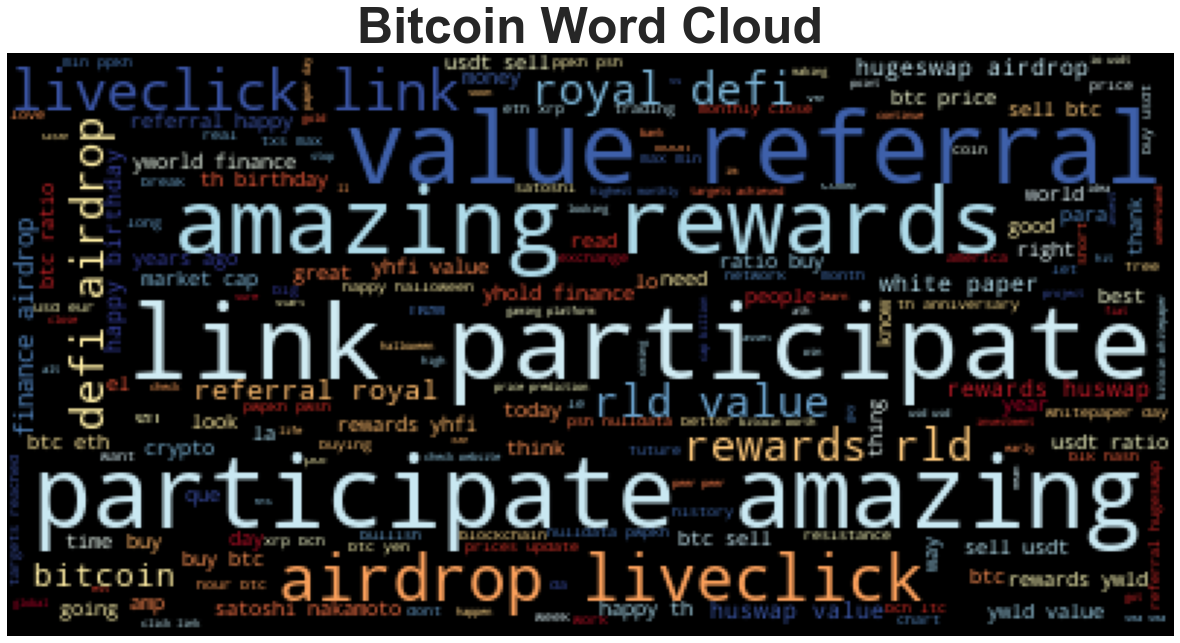

In [93]:
# Generate the Bitcoin word cloud
allWords = ' '.join([twts for twts in df_tweets['tweet']])
wordcloud = WordCloud(colormap="RdYlBu").generate(allWords)
plt.imshow(wordcloud)
plt.axis("off")
fontdict = {"fontsize": 50, "fontweight": "bold"}
plt.title("Bitcoin Word Cloud", fontdict=fontdict)
plt.show()

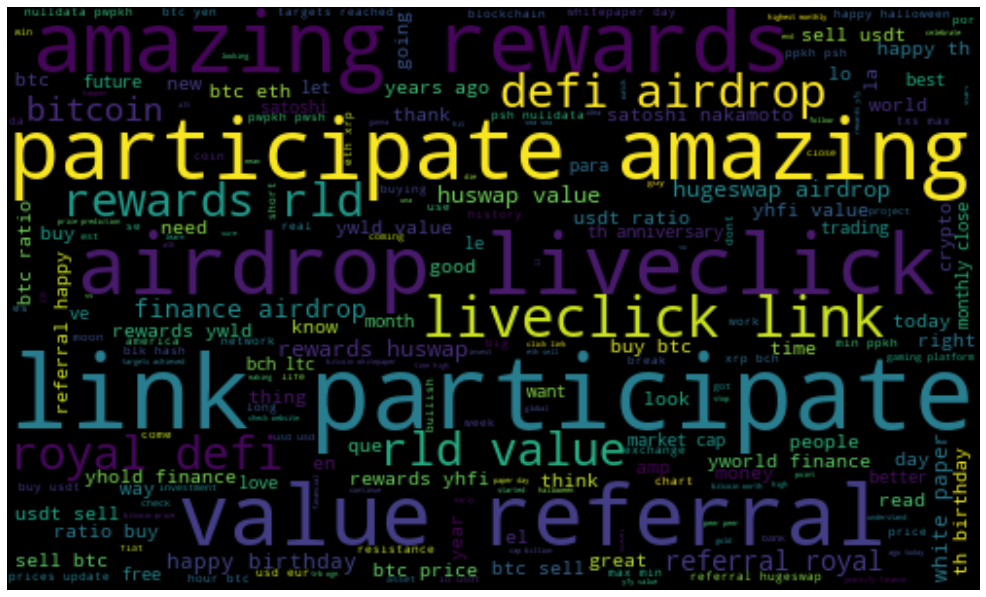

In [94]:
# word cloud visualization and potentially combine hashtags? 
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Function below computes the negative (-1), neutral (0), and positive (+1) analysis, and adds it to a new column called Analysis

In [95]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df_tweets['Analysis'] = df_tweets['Polarity'].apply(getAnalysis)
# Show the dataframe
df_tweets

date     screen_name  \
0      2020-10-31 23:58:52   Sarah85381260   
1      2020-10-31 23:59:40       TraderKoz   
2      2020-10-31 23:57:38     Solipsist18   
3      2020-10-31 23:58:01  Yayaya18948871   
4      2020-10-31 23:58:35      k_filippop   
...                    ...             ...   
15265  2020-10-31 10:53:04         D40five   
15266  2020-10-31 10:52:01        dabildor   
15267  2020-10-31 10:54:36          arcbtc   
15268  2020-10-31 10:54:42    didar_bekbau   
15269  2020-10-31 10:52:29        cityal60   

                                                   tweet  \
0      yworld finance airdrop liveclick link particip...   
1                                          makes new ath   
2                                        btc usd btc usd   
3      royal defi airdrop liveclick link participate ...   
4                                                          
...                                                  ...   
15265                                 happy birthday tmi   
15266  cretsiz bitcoin kazanmak ister misiniz telefon...   
15267  happy whitepaper day ve bob gt k saturday use ...   
15268                           happy whitepaper day fam   
15269  steadily rising break weekend big beneficiary ...   

                                                 hashtag  \
0      [Airdrop, Airdrops, blockchain, cryptocurrency...   
1                                              [Bitcoin]   
2                        [Bitcoin, Crypto, MasterMetals]   
3      [Airdrop, Airdrops, blockchain, cryptocurrency...   
4                                              [bitcoin]   
...                                                  ...   
15265                                          [Bitcoin]   
15266  [Bitcoin, BTC, altcoin, kriptopara, XRP, Airdr...   
15267                                          [bitcoin]   
15268                                          [Bitcoin]   
15269                            [Bitcoin, ARB, Bitcoin]   

                     emojis  \
0      [🚀💰🏆, 🎁, 🎁, 🎁, 💰, 👥]   
1                        []   
2                        []   
3      [🚀💰🏆, 🎁, 🎁, 🎁, 💰, 👥]   
4                        []   
...                     ...   
15265                    []   
15266          [Ü, ü, ı, ı]   
15267              [🤩🚀🌑, 🔧]   
15268                 [🎉🎉🎉]   
15269                  [🦉👍]   

                                                  tokens  Subjectivity  \
0      yworld finance airdrop liveclick link particip...      0.900000   
1                                          makes new ath      0.454545   
2                                        btc usd btc usd      0.000000   
3      royal defi airdrop liveclick link participate ...      0.900000   
4                                                             0.000000   
...                                                  ...           ...   
15265                                 happy birthday tmi      1.000000   
15266  cretsiz bitcoin kazanmak ister misiniz telefon...      0.000000   
15267  happy whitepaper day ve bob gt k saturday use ...      1.000000   
15268                           happy whitepaper day fam      1.000000   
15269  steadily rising break weekend big beneficiary ...      0.507222   

       Polarity  Analysis  
0      0.600000  Positive  
1      0.136364  Positive  
2      0.000000   Neutral  
3      0.600000  Positive  
4      0.000000   Neutral  
...         ...       ...  
15265  0.800000  Positive  
15266  0.000000   Neutral  
15267  0.800000  Positive  
15268  0.800000  Positive  
15269  0.206667  Positive  

[14971 rows x 9 columns]

Prints the positive tweets in ascending order. The most positive tweet is the #1 tweet.

In [96]:
# Printing positive tweets 
print('Printing positive tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analysis'][i] == 'Positive'):
        print(str(j) + ') '+ sortedDF['tweet'][i])
        print()
        j= j+1

Printing positive tweets:

1) yworld finance airdrop liveclick link participate amazing rewards ywld value referral

2) makes new ath

3) royal defi airdrop liveclick link participate amazing rewards rld value referral

4) yworld finance airdrop liveclick link participate amazing rewards ywld value referral

5) million number divisible numbers cosmic power propagate new consciousness value

6) let s yfi holy kore hate uni farm inj xvs sxp fio easy bot kpr surf yeld core pria kper orai fmta tens stacy nice prq pols stake ocean bond

7) happy birthday

8) chart shows interesting phenomenon needs consecutive days price hold floor

9) speed finance airdrop liveclick link participate amazing rewards spfi value referral

10) royal defi airdrop liveclick link participate amazing rewards rld value referral

11) royal defi airdrop liveclick link participate amazing rewards rld value referral

12) love

13) damn guys ve btc maxi feel embarrassed lol love alts buuuuuut btc

14) super running coin

KeyError: 50

Prints the negative tweets in ascending order. The most negative tweet is the #1 tweet.

In [97]:
# Printing negative tweets  
print('Printing negative tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analysis'][i] == 'Negative'):
        print(str(j) + ') '+sortedDF['tweet'][i])
        print()
        j=j+1

Printing negative tweets:

1) play cashback play higher rank cashback username user

2) optimal portfolio past hours given return s level

3) blockfi earn apy borrow cash trade currencies hidden fees minimum balances



KeyError: 50

### Fix statement below
Plot the polarity and subjectivity as a scatter plot. It looks like the majority of the tweets are positive, as many of the points are on the right side of the polarity at value 0.00.

In [59]:
# Plotting 
plt.figure(figsize=(8,6)) 
for i in range(0, df_tweets.shape[0]):
    plt.scatter(df_tweets["Polarity"][i], df_tweets["Subjectivity"][i], color='Blue') 
# plt.scatter(x,y,color)   
# plt.title('Sentiment Analysis') 
# plt.xlabel('Polarity') 
# plt.ylabel('Subjectivity') 
# plt.show()

KeyError: 50

Print the percentage of positive tweets. About 43.6% of the tweets are considered positive tweets.

In [98]:
# Print the percentage of positive tweets
ptweets = df_tweets[df_tweets.Analysis == 'Positive']
ptweets = ptweets['tweet']
ptweets

round( (ptweets.shape[0] / df_tweets.shape[0]) * 100 , 1)

42.6

Print the percentage of negative tweets. About 5.2% of the tweets are considered negative tweets.

In [99]:
# Print the percentage of negative tweets
ntweets = df_tweets[df_tweets.Analysis == 'Negative']
ntweets = ntweets['tweet']
ntweets

round( (ntweets.shape[0] / df_tweets.shape[0]) * 100, 1)

5.3

In [100]:
# Show the value counts
df_tweets['Analysis'].value_counts()

Neutral     7803
Positive    6375
Negative     793
Name: Analysis, dtype: int64

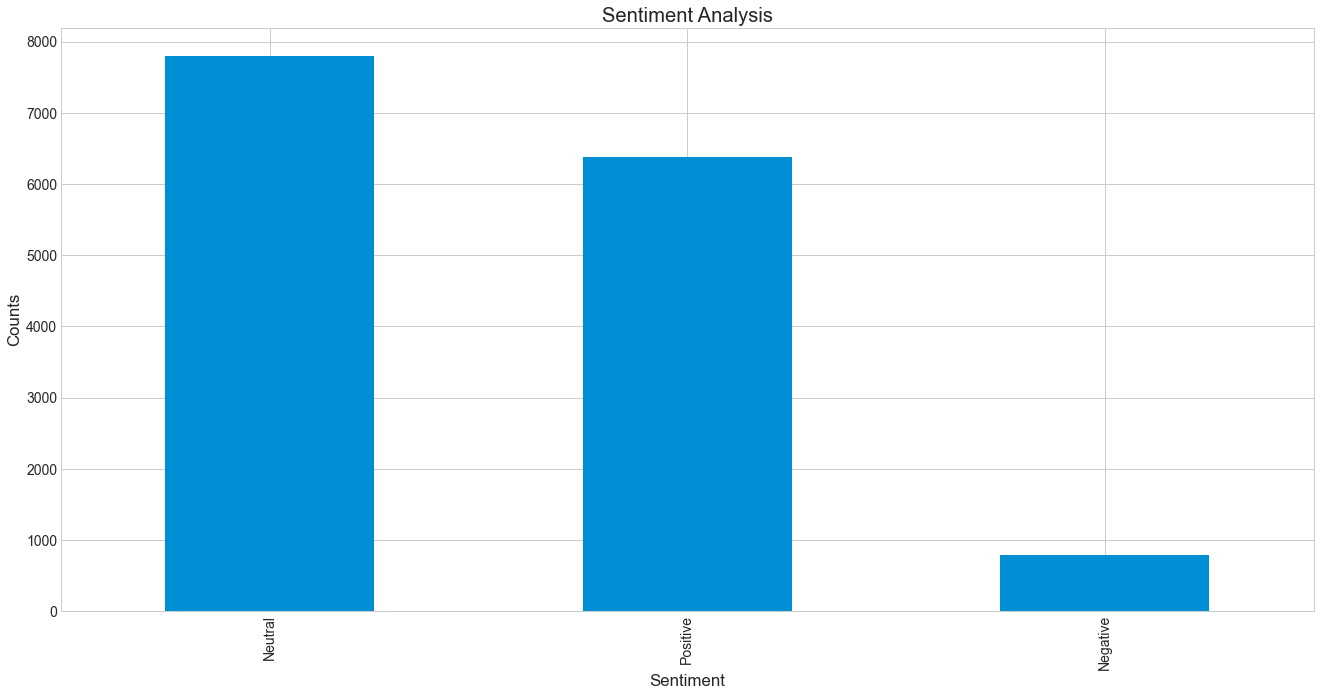

In [101]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_tweets['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

# Named Entity Recognition

In this section, you will build a named entity recognition model for both coins and visualize the tags using SpaCy.

## Bitcoin NER

In [66]:
# Concatenate all of the bitcoin text together
flat_btc_text_str = " ".join(df_tweets.tweet.to_list())
print(flat_btc_text_str)

yworld finance airdrop liveclick link participate amazing rewards ywld value referral makes new ath btc usd btc usd royal defi airdrop liveclick link participate amazing rewards rld value referral  play cashback play higher rank cashback username user btc usd btc usd thank yworld finance airdrop liveclick link participate amazing rewards ywld value referral btc usd btc usd   million number divisible numbers cosmic power propagate new consciousness value let s yfi holy kore hate uni farm inj xvs sxp fio easy bot kpr surf yeld core pria kper orai fmta tens stacy nice prq pols stake ocean bond happy birthday chart shows interesting phenomenon needs consecutive days price hold floor btc usd btc usd speed finance airdrop liveclick link participate amazing rewards spfi value referral    royal defi airdrop liveclick link participate amazing rewards rld value referral la espiral la muerte min rejection coming getting freaky bcqpwngcxrkepjjmjyekfvchztqkepamhu btc hold hereif mother face rippers

In [67]:
# Run the NER processor on all of the text
btc_doc = nlp(flat_btc_text_str)
btc_doc.user_data["title"] = "Bitcoin NER"
# Add a title to the document

In [68]:
# Render the visualization
displacy.render(btc_doc,style='ent')

spaCy tokenizes text in an entirely nondestructive manner... The underlying text does not change... spaCy does not explicitly break the original text into a list, but tokens can be accessed by index span.

spaCy provides syntactic parsing to show word usage, thus creating a dependency tree

In [69]:
# List all Entities
for ent in btc_doc.ents:
    print(ent.text, ent.label_, ent.lemma_, ent.text)

yworld finance airdrop liveclick ORG yworld finance airdrop liveclick yworld finance airdrop liveclick
btc usd btc PERSON btc usd btc btc usd btc
xvs sxp PERSON xvs sxp xvs sxp
yeld core ORG yeld core yeld core
pria kper GPE pria kper pria kper
ocean bond PERSON ocean bond ocean bond
birthday chart PERSON birthday chart birthday chart
consecutive days DATE consecutive day consecutive days
la muerte PERSON la muerte la muerte
monday DATE monday monday
spx ndx PRODUCT spx ndx spx ndx
past hours TIME past hour past hours
btc usd btc usd  register PERSON btc usd btc usd   register btc usd btc usd  register
tronmin gh ORG tronmin gh tronmin gh
coin airdrop liveclick ORG coin airdrop liveclick coin airdrop liveclick
year DATE year year
minutes TIME minute minutes
years DATE year years
today years DATE today year today years
monthly DATE monthly monthly
ta video bitcoin dollar ORG ta video bitcoin dollar ta video bitcoin dollar
defi PERSON defi defi
tu futuro PERSON tu futuro tu futuro
el res

In [70]:
import scattertext as st
from spacy.symbols import amod
spacy.explain("amod")

'adjectival modifier'

In [71]:
for token in btc_doc:
    if token.dep_ == 'amod':
        print(f"ADJ MODIFIER: {token.text} --> NOUN: {token.head}")

ADJ MODIFIER: amazing --> NOUN: rewards
ADJ MODIFIER: new --> NOUN: btc
ADJ MODIFIER: amazing --> NOUN: referral
ADJ MODIFIER: higher --> NOUN: btc
ADJ MODIFIER: username --> NOUN: btc
ADJ MODIFIER: amazing --> NOUN: btc
ADJ MODIFIER: divisible --> NOUN: numbers
ADJ MODIFIER: cosmic --> NOUN: power
ADJ MODIFIER: new --> NOUN: value
ADJ MODIFIER: holy --> NOUN: kore
ADJ MODIFIER: easy --> NOUN: bot
ADJ MODIFIER: nice --> NOUN: bond
ADJ MODIFIER: happy --> NOUN: chart
ADJ MODIFIER: interesting --> NOUN: phenomenon
ADJ MODIFIER: consecutive --> NOUN: days
ADJ MODIFIER: amazing --> NOUN: link
ADJ MODIFIER: amazing --> NOUN: referral
ADJ MODIFIER: optimal --> NOUN: portfolio
ADJ MODIFIER: royal --> NOUN: defi
ADJ MODIFIER: amazing --> NOUN: btc
ADJ MODIFIER: global --> NOUN: wallet
ADJ MODIFIER: daysguider --> NOUN: love
ADJ MODIFIER: damn --> NOUN: guys
ADJ MODIFIER: embarrassed --> NOUN: alts
ADJ MODIFIER: running --> NOUN: link
ADJ MODIFIER: amazing --> NOUN: rewards
ADJ MODIFIER: unsust

### Named Entity Recognition
To see which tokens spaCy identifies as named entities... simply cycle through `btc_doc.ents`"

In [83]:
spacy.explain("GPE")

'Countries, cities, states'

In [84]:
for ent in btc_doc.ents:
    print(ent.text, ent.label_)

yworld finance airdrop liveclick ORG
xvs sxp PERSON
bot kp3r PERSON
pria kper GPE
ocean bond PERSON
consecutive days DATE
defi PERSON
la muerte PERSON
five CARDINAL
monday DATE
spx ndx PERSON
portfolio past hours TIME
btc usd btc PERSON
days10 referalmin ORG
damn PRODUCT
coin airdrop liveclick ORG
this year DATE
minutes TIME
last years DATE
today years DATE
monthly DATE
defi PERSON
el resultado ORG
el presenteque deciciones ORG
para tu PERSON
los que PERSON
que quienes compramos hace aos hemos seguido ORG
sistemticamente y lo seguiremos PERSON
lugar poder decidir comprar ORG
13820 CARDINAL
16 blk 654930 DATE
10 31t23 DATE
txs 1974 DATE
60 CARDINAL
99700000 PRODUCT
0 CARDINAL
1516 DATE
1047 DATE
defi PERSON
115 CARDINAL
000 PRODUCT
next year DATE
xvs sxp PERSON
bot kp3r PERSON
pria kper GPE
defi PERSON
october 53pm DATE
days10 referalmin ORG
kit airdrop live PERSON
100referral CARDINAL
monthly DATE
13803 2 week ago 0 months ago 0 year ago 10841 DATE
10 31t23 DATE
51 31z DATE
275a315c81c

## Scattertext

Scattertext is great for
- Visually inspecting text
- Comparing/Contrasting corpora

Jason Kessler's GitHub project for more information: [here](https://github.com/JasonKessler/scattertext).

In [105]:
df_tweets.head()

date     screen_name  \
0  2020-10-31 23:58:52   Sarah85381260   
1  2020-10-31 23:59:40       TraderKoz   
2  2020-10-31 23:57:38     Solipsist18   
3  2020-10-31 23:58:01  Yayaya18948871   
4  2020-10-31 23:58:35      k_filippop   

                                               tweet  \
0  yworld finance airdrop liveclick link particip...   
1                                      makes new ath   
2                                    btc usd btc usd   
3  royal defi airdrop liveclick link participate ...   
4                                                      

                                             hashtag                emojis  \
0  [Airdrop, Airdrops, blockchain, cryptocurrency...  [🚀💰🏆, 🎁, 🎁, 🎁, 💰, 👥]   
1                                          [Bitcoin]                    []   
2                    [Bitcoin, Crypto, MasterMetals]                    []   
3  [Airdrop, Airdrops, blockchain, cryptocurrency...  [🚀💰🏆, 🎁, 🎁, 🎁, 💰, 👥]   
4                                          [bitcoin]                    []   

                                              tokens  Subjectivity  Polarity  \
0  yworld finance airdrop liveclick link particip...      0.900000  0.600000   
1                                      makes new ath      0.454545  0.136364   
2                                    btc usd btc usd      0.000000  0.000000   
3  royal defi airdrop liveclick link participate ...      0.900000  0.600000   
4                                                         0.000000  0.000000   

   Analysis  
0  Positive  
1  Positive  
2   Neutral  
3  Positive  
4   Neutral

In [102]:
corpus = st.CorpusFromPandas(df_tweets,
                             category_col='Analysis',
                             text_col='tokens',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [104]:
#Doesn't work!!!
html = st.produce_scattertext_explorer(
        corpus,
        category='Positive',
        category_name='Positive',
        not_category_name='Negative',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=df_tweets['screen_name'],
        )

In [ ]:
open('scattertext_demo.html', 'wb').write(html.encode('utf-8'));

In [106]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_tweets['tokens'], df_tweets['Analysis'], test_size=0.3, random_state=42)

In [107]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

X_train_cv1_df = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()
X_train_cv1_df

#these words need to be removed!!!

aadaki  aaj  aan  aannnnnd  aapl  aarsa  aave  aavebuy  ab  abacus  ...  \
0       0    0    0         0     0      0     0        0   0       0  ...   
1       0    0    0         0     0      0     0        0   0       0  ...   
2       0    0    0         0     0      0     0        0   0       0  ...   
3       0    0    0         0     0      0     0        0   0       0  ...   
4       0    0    0         0     0      0     0        0   0       0  ...   

   zulauf  zum  zur  zurck  zurich  zustzliche  zut  zwei  zwischenzeitliches  \
0       0    0    0      0       0           0    0     0                   0   
1       0    0    0      0       0           0    0     0                   0   
2       0    0    0      0       0           0    0     0                   0   
3       0    0    0      0       0           0    0     0                   0   
4       0    0    0      0       0           0    0     0                   0   

   zwlften  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 13277 columns]

In [49]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

X_train_cv2_df = pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()
X_train_cv2_df

aa  aa krarsada  aadaki  aadaki linkin  aadaki linkten  aaj  aaj ka  aal  \
0   0            0       0              0               0    0       0    0   
1   0            0       0              0               0    0       0    0   
2   0            0       0              0               0    0       0    0   
3   0            0       0              0               0    0       0    0   
4   0            0       0              0               0    0       0    0   

   aan  aan andere  ...  zur profitablen  zurich  zurich airport  zustzliche  \
0    0           0  ...                0       0               0           0   
1    0           0  ...                0       0               0           0   
2    0           0  ...                0       0               0           0   
3    0           0  ...                0       0               0           0   
4    0           0  ...                0       0               0           0   

   zustzliche ordergebhren  zut  zut kore  zv  zwischenzeitliches  \
0                        0    0         0   0                   0   
1                        0    0         0   0                   0   
2                        0    0         0   0                   0   
3                        0    0         0   0                   0   
4                        0    0         0   0                   0   

   zwischenzeitliches tief  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 51590 columns]

## Classifying Using Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model to use
lr = LogisticRegression()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Keeps saying too many values to unpack for cells below

In [37]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

In [36]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [35]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

### Classifying Using Naive Bayes

In [39]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# Fit the first Naive Bayes model

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [40]:
# Fit the second Naive Bayes model

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

Same issue as above. Too many values to unpack

In [43]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

In [44]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [46]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

### TF-IDF

In [50]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

pd.DataFrame(X_train_tfidf1.toarray(), columns=tfidf1.get_feature_names()).head()

aa  aadaki  aaj  aal  aan  aannnnnd  aapl  aarsa  aave  aavebuy  ...  \
0  0.0     0.0  0.0  0.0  0.0       0.0   0.0    0.0   0.0      0.0  ...   
1  0.0     0.0  0.0  0.0  0.0       0.0   0.0    0.0   0.0      0.0  ...   
2  0.0     0.0  0.0  0.0  0.0       0.0   0.0    0.0   0.0      0.0  ...   
3  0.0     0.0  0.0  0.0  0.0       0.0   0.0    0.0   0.0      0.0  ...   
4  0.0     0.0  0.0  0.0  0.0       0.0   0.0    0.0   0.0      0.0  ...   

   zukunft  zulauf  zullen  zum  zur  zurich  zustzliche  zut   zv  \
0      0.0     0.0     0.0  0.0  0.0     0.0         0.0  0.0  0.0   
1      0.0     0.0     0.0  0.0  0.0     0.0         0.0  0.0  0.0   
2      0.0     0.0     0.0  0.0  0.0     0.0         0.0  0.0  0.0   
3      0.0     0.0     0.0  0.0  0.0     0.0         0.0  0.0  0.0   
4      0.0     0.0     0.0  0.0  0.0     0.0         0.0  0.0  0.0   

   zwischenzeitliches  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  

[5 rows x 13160 columns]

In [51]:
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

pd.DataFrame(X_train_tfidf2.toarray(), columns=tfidf2.get_feature_names()).head()

aa  aa krarsada  aadaki  aadaki linkin  aadaki linkten  aaj  aaj ka  aal  \
0  0.0          0.0     0.0            0.0             0.0  0.0     0.0  0.0   
1  0.0          0.0     0.0            0.0             0.0  0.0     0.0  0.0   
2  0.0          0.0     0.0            0.0             0.0  0.0     0.0  0.0   
3  0.0          0.0     0.0            0.0             0.0  0.0     0.0  0.0   
4  0.0          0.0     0.0            0.0             0.0  0.0     0.0  0.0   

   aan  aan andere  ...  zur profitablen  zurich  zurich airport  zustzliche  \
0  0.0         0.0  ...              0.0     0.0             0.0         0.0   
1  0.0         0.0  ...              0.0     0.0             0.0         0.0   
2  0.0         0.0  ...              0.0     0.0             0.0         0.0   
3  0.0         0.0  ...              0.0     0.0             0.0         0.0   
4  0.0         0.0  ...              0.0     0.0             0.0         0.0   

   zustzliche ordergebhren  zut  zut kore   zv  zwischenzeitliches  \
0                      0.0  0.0       0.0  0.0                 0.0   
1                      0.0  0.0       0.0  0.0                 0.0   
2                      0.0  0.0       0.0  0.0                 0.0   
3                      0.0  0.0       0.0  0.0                 0.0   
4                      0.0  0.0       0.0  0.0                 0.0   

   zwischenzeitliches tief  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  

[5 rows x 51590 columns]

In [50]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

In [ ]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

In [ ]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

In [ ]:
# Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm8 = conf_matrix(y_test, y_pred_tfidf2_nb)

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm7, cm8)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results

## Topic Modeling with Matrix Factorization

### Latent Semantic Analysis (LSA)

Sklearn's TruncatedSVD is designed to perform singular value decomposition on a count vectorizer or TF-IDF vectorizer object. Read up on the [documentation](https://scikit-learn.org/stable/modules/decomposition.html), which also discusses NMF and LDA.

> TruncatedSVD is very similar to PCA, but differs in that the matrix *X* does not need to be centered. When the columnwise (per-feature) means of *X* are subtracted from the feature values, truncated SVD on the resulting matrix is equivalent to PCA. In practical terms, this means that the TruncatedSVD transformer accepts scipy.sparse matrices without the need to densify them, as densifying may fill up memory even for medium-sized document collections.

> While the TruncatedSVD transformer works with any feature matrix, using it on tf–idf matrices is recommended over raw frequency counts in an LSA/document processing setting. In particular, sublinear scaling and inverse document frequency should be turned on (sublinear_tf=True, use_idf=True) to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data.

In [108]:
# Latent Semantic Analysis (LSA) is just another name for Singular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(2)
btc_doc_topic = lsa.fit_transform(X_train_cv1)
lsa.explained_variance_ratio_

array([0.15875101, 0.03343506])

The U matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:
- Component 1 (topic 1) seems to be about ...
- Component 2 (topic 2) seems to be about ...

In [109]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2"],
             columns = cv1.get_feature_names())
topic_word

aadaki  aaj  aan  aannnnnd  aapl  aarsa  aave  aavebuy   ab  \
component_1     0.0  0.0  0.0       0.0   0.0    0.0   0.0    0.000  0.0   
component_2     0.0  0.0  0.0       0.0   0.0    0.0   0.0    0.001  0.0   

             abacus  ...  zulauf  zum  zur  zurck  zurich  zustzliche  zut  \
component_1     0.0  ...     0.0  0.0  0.0    0.0     0.0         0.0  0.0   
component_2     0.0  ...     0.0  0.0  0.0    0.0     0.0         0.0  0.0   

             zwei  zwischenzeitliches  zwlften  
component_1   0.0                 0.0      0.0  
component_2   0.0                 0.0      0.0  

[2 rows x 13277 columns]

In [110]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [111]:
display_topics(lsa, cv1.get_feature_names(), 5)


Topic  0
link, referral, airdrop, value, amazing

Topic  1
btc, sell, ratio, usdt, buy


The Vt matrix shows us the documents we started with, and how each document is made up of the # resulting topics. In this case:
- The first ### documents seem to be about ...
- The last ### documents seem to be about ...

In [112]:
Vt = pd.DataFrame(btc_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2" ])
Vt

component_1  component_2
tokens                                                                      
bsv vs ltc                                              0.00190      0.04322
happy th birthday bitcoin oct set motion revolu...      0.05306      0.22514
sure users retweet comment receive mt perfect f...      0.00040      0.00693
happy th anniversary satoshi nakamoto s white p...      0.00161      0.09945
market update price currently btc view coin             0.00276      0.95813
...                                                         ...          ...
im fortunate high profile amp trading group mem...      0.00472      0.91876
poder del seor america                                  0.00003      0.01433
wow big giveaway sirthanks giveaway hope win li...      0.00017      0.01606
month read jpsh t better dca month                      0.00029      0.02370
congrats guts long k zone including reaccumulat...      0.00202      0.83279

[10479 rows x 2 columns]

Looking at cosine similarity, you can see that two documents both high in component 2 will have a similarity of 1, and two documents high in different components will have a similarity of 0.

In [113]:
cosine_similarity(Vt)

array([[1.        , 0.98246973, 0.99990584, ..., 0.99944401, 0.99949769,
        0.9991387 ],
       [0.98246973, 1.        , 0.98493545, ..., 0.97570784, 0.97606815,
        0.97388787],
       [0.99990584, 0.98493545, 1.        , ..., 0.99889236, 0.99896867,
        0.99847518],
       ...,
       [0.99944401, 0.97570784, 0.99889236, ..., 1.        , 0.99999864,
        0.99996671],
       [0.99949769, 0.97606815, 0.99896867, ..., 0.99999864, 1.        ,
        0.99995188],
       [0.9991387 , 0.97388787, 0.99847518, ..., 0.99996671, 0.99995188,
        1.        ]])

In [114]:
cos_dtm = cosine_similarity(X_train_cv1_df).round(2)
cos_dtm

array([[1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.16, 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.16, 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ]])

### Non-Negative Matrix Factorization (NMF)

In this example, we are going to start with 6 documents that contain many unique words (or features). The goal is to reduce those words down into 2 topics, so that each document can be represented as some combination of the 2 topics. We will be using NMF this time around.

In [59]:
nmf_model = NMF(2)
btc_nmf_doc_topic = nmf_model.fit_transform(X_train_cv1)

The W matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:
- Component 1 (topic 1) seems to be about ###
- Component 2 (topic 2) seems to be about ###

In [60]:
topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2"],
             columns = cv1.get_feature_names())
topic_word_nmf

aa  aadaki  aaj    aal    aan  aannnnnd   aapl  aarsa   aave  \
component_1  0.0   0.000  0.0  0.000  0.000       0.0  0.000  0.000  0.000   
component_2  0.0   0.003  0.0  0.002  0.002       0.0  0.002  0.002  0.007   

             aavebuy  ...  zukunft  zulauf  zullen    zum  zur  zurich  \
component_1     0.00  ...      0.0     0.0   0.000  0.000  0.0     0.0   
component_2     0.01  ...      0.0     0.0   0.002  0.002  0.0     0.0   

             zustzliche    zut   zv  zwischenzeitliches  
component_1         0.0  0.001  0.0                 0.0  
component_2         0.0  0.003  0.0                 0.0  

[2 rows x 13160 columns]

In [61]:
display_topics(nmf_model, cv1.get_feature_names(), 10)


Topic  0
link, airdrop, value, amazing, participate, referral, rewards, liveclick, defi, rld

Topic  1
btc, sell, ratio, usdt, buy, eth, bitcoin, usd, price, ltc


The H matrix shows us the documents we started with, and how each document is made up of the 2 resulting topics. In this case:
- The first document seems to be about ...
- The last document seems to be about ...
- Everything in between is a combination of the two

In [62]:
H = pd.DataFrame(btc_nmf_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2" ])
H

component_1  component_2
tokens                                                                      
yearnify finance airdrop liveclick link partici...      0.22915      0.00013
facebook censura la etiqueta su plataforma              0.00000      0.00135
our real vote counts currency decide trust use ...      0.00006      0.00144
this guy good job right at spreading adoption k...      0.00003      0.00150
happy bitcoin whitepaper day                            0.00003      0.01787
...                                                         ...          ...
o valor mdio das criptomoedas bitcoin btc r lit...      0.00000      0.14886
this going years its compete digital currency s...      0.00006      0.00425
                                                        0.00000      0.00000
youre like to and mfr loves it                          0.00002      0.00153
i love all                                              0.00000      0.00040

[10478 rows x 2 columns]

In [48]:
# Set categories
categories = ['bitcoin', 'paypal', 'crypto']

# Download the training subset of the 20 NG dataset, with headers, footers, quotes removed
# Only keep docs from the 6 categories above
ng_train = X_train_cv1_df(subset='train', categories=categories, 
                                      remove=('headers', 'footers', 'quotes'))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: 'DataFrame' object is not callable

## Topic Modeling with sklearn and pyLDAvis

Adapted from [the official pyLDAvis repo demo](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb).

We'll try out [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) on the [20 Newsgroups dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) with some simple preprocessing.

In [115]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(X_train)
print(dtm_tf.shape)

(10479, 1061)


In [116]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(dtm_tfidf.shape)

(10479, 1061)


### Fit the Latent Dirichlet Allocation models

In [117]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

## pyLDAvis

Recall the # categories we extracted:

* ...
* ...

Let's use [pyLDAvis](http://bl.ocks.org/AlessandraSozzi/raw/ce1ace56e4aed6f2d614ae2243aab5a5/) to see our topics, and to see if they match up with our expectations.

* The left panel visualizes the topics as circles in the two-dimensional plane whose centres are determined by computing the Jensen–Shannon divergence between topics, and then by using [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) to project the inter-topic distances onto two dimensions. Each topic’s overall prevalence is encoded using the areas of the circles.

* The right panel depicts a horizontal bar chart whose bars represent the individual terms that are the most useful for interpreting the currently selected topic on the left. A pair of overlaid bars represent both the corpus-wide frequency of a given term as well as the topic-specific frequency of the term.

* The λ slider allows to rank the terms according to term relevance. By default, the terms of a topic are ranked in decreasing order according their topic-specific probability ( λ = 1 ). Moving the slider allows to adjust the rank of terms based on much discriminatory (or "relevant") are for the specific topic. The suggested “optimal” value of λ is 0.6. [Small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic.](http://www.kennyshirley.com/LDAvis/)

In [119]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.459028 -0.083889       1        1  21.558320
16     0.454376 -0.079095       2        1  12.041961
9     -0.131379 -0.072702       3        1   6.971763
8     -0.068127  0.042972       4        1   6.180647
7     -0.094159  0.106053       5        1   5.286721
19    -0.123041 -0.214113       6        1   4.584403
15    -0.100420 -0.291671       7        1   4.396883
11    -0.063945  0.146769       8        1   4.057141
2      0.104210  0.139797       9        1   3.964287
13    -0.035423  0.092539      10        1   3.830210
18    -0.083780 -0.093246      11        1   3.822411
4     -0.039941  0.152402      12        1   3.559667
17    -0.087841 -0.135962      13        1   3.092618
12    -0.063478 -0.107462      14        1   3.019601
6      0.027357  0.127576      15        1   2.667129
0     -0.071756 -0.024475      16        1   2.502860
1     -0.029826  0.025384      17        1   2.375513
10    -0.000325  0.060034      18        1   2.223584
5     -0.017072  0.144621      19        1   2.041578
3     -0.034460  0.064467      20        1   1.822704, topic_info=            Term         Freq        Total Category  logprob  loglift
122          btc  1443.000000  1443.000000  Default  30.0000  30.0000
31       amazing  1910.000000  1910.000000  Default  29.0000  29.0000
649  participate  1890.000000  1890.000000  Default  28.0000  28.0000
764      rewards  1883.000000  1883.000000  Default  27.0000  27.0000
524    liveclick  1863.000000  1863.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
430         hour    28.986339   113.380373  Topic20  -3.6415   2.6409
871       supply    18.228102    37.475336  Topic20  -4.1054   3.2841
397     hashrate    16.053232    27.278075  Topic20  -4.2325   3.4747
734      reached    14.856047    72.393733  Topic20  -4.3100   2.4211
697        price    16.032090   460.075885  Topic20  -4.2338   0.6481

[910 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         3  0.239616  according
4        17  0.718848  according
7         9  0.962682   achieved
8         9  0.071059        act
8        17  0.852713        act
...     ...       ...        ...
1057      9  0.894383        zil
1057     15  0.083198        zil
1058     20  0.967964        ziz
1059     20  0.967964       zize
1060     11  0.954573     zombie

[1360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 17, 10, 9, 8, 20, 16, 12, 3, 14, 19, 5, 18, 13, 7, 1, 2, 11, 6, 4])

The topics for our TFIDFVectorizer LDA also appear to match up with our newsgroups categories, though not as cleanly:

#### Change below!!!
* Topic 1: people (unclear)
* Topic 2: israel, jews ('talk.politics.mideast')
* Topic 3: space, NASA ('sci.space')
* Topic 4: files, graphics ('comp.graphics')
* Topic 5: games, baseball ('rec.sport.baseball')
* Topic 6: yankees, planetary (unclear)

Overall, it appears that with minimal text preprocessing, LDA was still able to extract the relevant topics from our corpus. It appears as though some miscellaneous terms are still floating around in our topics - additional text preprocessing, particularly stop word removal, is needed!

Let's revisit the CountVectorizer LDA model. We can adjust multidimensional scaling to get "cleaner" topic bubbles.

In [120]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.498389  0.141077       1        1  21.558320
16     0.470507  0.197535       2        1  12.041961
9     -0.069279 -0.202906       3        1   6.971763
8     -0.449637 -0.121262       4        1   6.180647
7      0.115094 -0.208094       5        1   5.286721
19    -0.273707 -0.254518       6        1   4.584403
15    -0.272293 -0.381889       7        1   4.396883
11    -0.081426  0.110197       8        1   4.057141
2      0.128133  0.449420       9        1   3.964287
13     0.365507 -0.289863      10        1   3.830210
18     0.159432 -0.409250      11        1   3.822411
4     -0.059682  0.435030      12        1   3.559667
17     0.142345  0.055864      13        1   3.092618
12    -0.309442  0.318150      14        1   3.019601
6      0.220192  0.305900      15        1   2.667129
0     -0.166463  0.260906      16        1   2.502860
1     -0.319471  0.004914      17        1   2.375513
10    -0.453798  0.182118      18        1   2.223584
5      0.377789 -0.125703      19        1   2.041578
3     -0.022190 -0.467626      20        1   1.822704, topic_info=            Term         Freq        Total Category  logprob  loglift
122          btc  1443.000000  1443.000000  Default  30.0000  30.0000
31       amazing  1910.000000  1910.000000  Default  29.0000  29.0000
649  participate  1890.000000  1890.000000  Default  28.0000  28.0000
764      rewards  1883.000000  1883.000000  Default  27.0000  27.0000
524    liveclick  1863.000000  1863.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
430         hour    28.986339   113.380373  Topic20  -3.6415   2.6409
871       supply    18.228102    37.475336  Topic20  -4.1054   3.2841
397     hashrate    16.053232    27.278075  Topic20  -4.2325   3.4747
734      reached    14.856047    72.393733  Topic20  -4.3100   2.4211
697        price    16.032090   460.075885  Topic20  -4.2338   0.6481

[910 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         3  0.239616  according
4        17  0.718848  according
7         9  0.962682   achieved
8         9  0.071059        act
8        17  0.852713        act
...     ...       ...        ...
1057      9  0.894383        zil
1057     15  0.083198        zil
1058     20  0.967964        ziz
1059     20  0.967964       zize
1060     11  0.954573     zombie

[1360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 17, 10, 9, 8, 20, 16, 12, 3, 14, 19, 5, 18, 13, 7, 1, 2, 11, 6, 4])

In [121]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
14     -10.878068   10.538728       1        1  21.558320
16     -60.884026  -75.591820       2        1  12.041961
9       -2.336119  -53.289074       3        1   6.971763
8      -61.385319  -12.914634       4        1   6.180647
7      -28.737743  126.296997       5        1   5.286721
19       1.066606 -123.552811       6        1   4.584403
15      45.140720   -7.947869       7        1   4.396883
11    -140.795975  -98.530548       8        1   4.057141
2       61.531681  -83.240562       9        1   3.964287
13     -72.563057 -140.396881      10        1   3.830210
18      15.984491   63.578186      11        1   3.822411
4     -160.851624   68.945145      12        1   3.559667
17      85.961830   51.922935      13        1   3.092618
12     -99.020836  109.936348      14        1   3.019601
6     -176.764130   -8.681684      15        1   2.667129
0     -117.189880  -37.420200      16        1   2.502860
1      108.829918  -22.946203      17        1   2.375513
10      47.588097  121.934814      18        1   2.223584
5     -106.467834   30.176889      19        1   2.041578
3      -50.613804   59.328842      20        1   1.822704, topic_info=            Term         Freq        Total Category  logprob  loglift
122          btc  1443.000000  1443.000000  Default  30.0000  30.0000
31       amazing  1910.000000  1910.000000  Default  29.0000  29.0000
649  participate  1890.000000  1890.000000  Default  28.0000  28.0000
764      rewards  1883.000000  1883.000000  Default  27.0000  27.0000
524    liveclick  1863.000000  1863.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
430         hour    28.986339   113.380373  Topic20  -3.6415   2.6409
871       supply    18.228102    37.475336  Topic20  -4.1054   3.2841
397     hashrate    16.053232    27.278075  Topic20  -4.2325   3.4747
734      reached    14.856047    72.393733  Topic20  -4.3100   2.4211
697        price    16.032090   460.075885  Topic20  -4.2338   0.6481

[910 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         3  0.239616  according
4        17  0.718848  according
7         9  0.962682   achieved
8         9  0.071059        act
8        17  0.852713        act
...     ...       ...        ...
1057      9  0.894383        zil
1057     15  0.083198        zil
1058     20  0.967964        ziz
1059     20  0.967964       zize
1060     11  0.954573     zombie

[1360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 17, 10, 9, 8, 20, 16, 12, 3, 14, 19, 5, 18, 13, 7, 1, 2, 11, 6, 4])

## On your own...

- Look at different subsets of the 20newsgroups dataset  
- Try performing LDA on this data with gensim (see `additional_resources` subdirectory)
- Play with some of the preprocessing options and parameters for LDA, observe what happens
- See if you can use the resulting topic space to extract topic vectors
- How do your results look?
- Can you think of how you could cluster this data? (k-means lecture)

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [122]:
from collections import Counter
from nltk import ngrams

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
# Tweets need to be cleaned!!!
# Generate the Bitcoin N-grams where N=2
flat_btc_tokens = [item for sublist in df_tweets.tweet.to_list() for item in sublist]
bigram_counts = Counter(ngrams(flat_btc_tokens, n=2))
bigram_counts.most_common(20)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(('e', ' '), 17675),
 (('i', 'n'), 16971),
 (('s', ' '), 13529),
 (('r', 'e'), 12655),
 (('l', 'i'), 12018),
 (('a', 'l'), 11656),
 ((' ', 'r'), 11250),
 (('a', 'r'), 11177),
 ((' ', 'a'), 10216),
 (('e', 'r'), 10116),
 ((' ', 'l'), 9853),
 ((' ', 'p'), 9100),
 ((' ', 'b'), 8745),
 (('i', 'c'), 8494),
 (('k', ' '), 8385),
 (('t', 'e'), 8263),
 (('t', ' '), 8170),
 (('p', 'a'), 7976),
 (('d', ' '), 7854),
 ((' ', 's'), 7785)]

In [71]:
# Use the token_count function to generate the top 10 words from each coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [72]:
# Get the top 10 words for Bitcoin
token_count(flat_btc_tokens)

[(' ', 143830),
 ('e', 82234),
 ('a', 70621),
 ('i', 64852),
 ('r', 62860),
 ('t', 51282),
 ('l', 45385),
 ('n', 43207),
 ('o', 42085),
 ('s', 39111)]

## CorEx Topic Modeling

* __Ways to Use CorEx__
   * _Try a different topic modeling package_
   * _Use your domain knowledge_
   * _Highlight smaller topics that may be otherwise hidden by larger topics_
   * _To see how the same word can be used in different topics_
   * _Create hierarchical topic models (will not be reviewed - tends to not work that well)_

### How CorEx Works
__As a comparison, LDA is a generative model, which starts from Y (documents/words) to determine X (topic models)__
  * Assumes that in the backend, X (topic models) ultimately generates Y (documents)
      * Question to answer is "How was Y generated?"
  * You need to actually find what X is

* Uses fancy math to find X, and you get two matrices:
  * Probability of word given a topic
  * Probability of topic given a document

__CorEx is a discriminative model, which starts from X (documents/words) to determine Y (topics models)__
  * This should make sense, as it's more or less how humans try to do determine topics when reading lots of documents 
      * Question to answer is "How do we group X?"
  * Basically, this means that LDA and CorEx are different, so one might work better than another in some contexts

__CorEx looks for groups of words that are in the same topic AKA have high Total Correlation (TC) AKA convey the same *information*__
  * Information can be defined as entropy
    * Think of entropy as how many documents a word might appear (this is NOT THE RIGHT definition, but will help you get an intuitive understanding)

* Specifically, TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If words are TIGHTLY RELATED (always appear together in the same topic/document), TC will be high. This is a good topic.__
  * TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If entropy('basket') = 8, entropy('ball') = 8, entropy('player') = 8 and *they overlap exactly*, entropy(group) = 8__

* entropy('basket') + entropy('ball') + entropy('player') - entropy(group) = 8 + 8 + 8 - 8 = 16

__If the words are all INDEPENDENT (never appear together in the same document or topic), TC = 0. This is a bad topic.__
  * TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If entropy('politics') = 8 and entropy('family') = 8, and there is no overlap, entropy(group) = 16__

 * entropy('politics') + entropy('family') - entropy(group) = 8 + 8 - 16 = 0

__CorEx looks for a group of words that are both as broad (in many documents) and overlapping as possible (both together will lead to high TC)__
  * This is a topic

__Then, you look for another set of words (not overlapping with your previous group) with as high a TC as possible__
  * This is your next topic

  * __As you create more topics, each subsequent topic will have lower TC__
    * As there are fewer words left, "pool of entropy" to choose from is smaller
    * Harder to find many related many words that are overlapping as the low hanging fruit has already been put into topics

### CorEx Setup

In [129]:
# Install CorEx 
# !pip install corextopic
# !pip install networkx

# Import other packages for examples
import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pre-process the data

Note that the default for CorEx is to use CountVectorizer with __binary=True__.

It has not been tested, so the makers of CorEx cannot vouch for it, but if you have large documents, it may be worth trying splitting into shorter documents, TF-IDF, binary=False, average binary bag of words, etc.

In [126]:
vectorizer = CountVectorizer(max_features=20000,
                             stop_words='english', token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(X_train)
words = list(np.asarray(vectorizer.get_feature_names()))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Ways to use CorEx

In [130]:
# n_hidden is the number of topics
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=X_train)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Output Code: What are my topic?

In [131]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: participate,airdrop,amazing,liveclick,rewards,referral,value,link,rld,royal
1: eos,cap,trb,username,qnt,gaming,mitx,nulldata,ppkh,txs
2: ratio,sell,el,la,en,que,usdt,los,para,aos
3: like,people,amp,money,world,targets,know,reached,new,free
4: paper,white,whitepaper,happy,th,satoshi,years,birthday,nakamoto,day
5: bch,ltc,close,xrp,monthly,eth,hour,highest,price,time
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


What am I looking for exactly?

### What are the top tweets associated with a topic?

In [132]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=4, n_docs=2)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('goldhorn crypto welcomes vision capital market union cmu includes framework regulation amp oversight visit',
  0.0),
 ('buen da para agradecerle estos seores hal finney reusable pow adam hashcash wei dai b money david chaum digicash nick szabo bitgold phil zimmermann pgp bram cohen bittorrent tim crypto anarchist manifestoy mr nakamoto',
  0.0)]

### How do I see which topics CorEx has put each document in?

Use the .labels attribute to find the topic labels associated with each document that you trained on.

Use the .predict() method to predict labels based on a __new doc_word__

In [133]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(6)])
predictions.head(3)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic0  topic1  topic2  topic3  topic4  topic5
0   False    True   False    True   False    True
1   False    True   False   False    True    True
2   False    True   False   False   False    True

Note that some documents have 0 topics, and some documents have more than 1 topic
  * You can also use .p_y_given_x for for probabilities instead of True/False

### How do I determine how many topics I should have?
The makers of CorEx have a created a cool plotting function to see what the TC of each topic is. 
  * Look for an elbow (either at 1 topic or 4 topics) and you can create a cut-off there

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


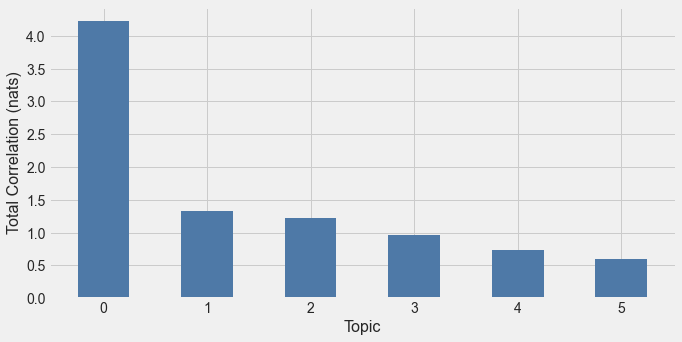

In [134]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

"I'm not a huge fan of this (doesn't work that well, I think). I prefer taking the clean topics (e.g., 3 topics), anchoring them to hold them more or less fixed (next slide), then re-running CorEx with extra topics (e.g., 6), to see if any new clean topics come out. 
  * Repeat the above until topics are clean"

### What should I be doing exactly?

### Ways to Use CorEx
  * Use your domain knowledge (use anchors)
  * Use low anchor strength (2) in order to have as broad a match as possible

In [137]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
                anchors=[['bitcoin'], 
                         ['ath'], 
                         ['moon'], 
                         ['btc'],
                         ['buy'], 
                         ['hodl']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0: bitcoin,happy,birthday,paper,white,whitepaper,years,satoshi,th,nakamoto
1: ath,targets,reached,qnt,mitx,zil,poe,mbl,troy,trb
2: like,moon,amp,people,money,new,going,need,know,way
3: btc,eth,bch,ltc,usd,price,xrp,monthly,eur,close
4: participate,airdrop,liveclick,amazing,rewards,referral,value,link,rld,royal
5: en,el,la,que,para,los,aos,es,del,se


### Ways to Use CorEx
  * __Highlight smaller topics that may be otherwise hidden by larger topics (use anchors)__
  * Use high anchor strength (5+) in order to force topics
    * Likely means that there will be fewer documents matched to the topic

In [139]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
#Why the double brackets??
                anchors=[['buy', 'bitcoin'], 'ethereum'], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0: bitcoin,buy,sell,low,cap,cash,melhor,ripple,walltimer,venda
1: ethereum,el,en,la,ltc,bch,que,eth,del,xrp
2: participate,airdrop,amazing,liveclick,rewards,referral,value,link,rld,royal
3: happy,birthday,th,anniversary,oct,day,whitepaper,eur,gmt,recommended
4: paper,white,satoshi,years,nakamoto,ago,released,hash,retweet,published
5: time,close,people,monthly,like,amp,going,new,today,highest


### Ways to Use CorEx
  * __To see how the same word can be used in different topics (use anchors)__
  * Anchor the same word multiple times

In [140]:
topic_model = ct.Corex(n_hidden=8, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
                anchors=[['hodl'], ['hodl'], ['hodl'], ['hodl']], anchor_strength=5)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0: bch,ltc,hodl,amp,people,money,join,usd,eur,check
1: el,hodl,que,en,la,del,los,aos,para,se
2: hodl,max,mitx,pwpkh,pwsh,psh,nulldata,ppkh,blk,txs
3: years,paper,white,today,satoshi,hodl,nakamoto,close,monthly,ago
4: btc,sell,ratio,price,usdt,eth,oct,update,prediction,buy
5: participate,airdrop,amazing,liveclick,rewards,referral,value,link,rld,royal
6: targets,username,experience,trb,gaming,poe,trick,qnt,iotx,ren
7: happy,birthday,th,anniversary,halloween,cap,market,retweet,billion,worth


### Resources and other ways to use CorEx

Take a look at the Github rep:
  * Main page: https://github.com/gregversteeg/corex_topic
  * Example notebook (MUST READ!): https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb
  
Things to try:
  * Making documents shorter / longer
  * TF-IDF
  * Average binary bag of words
  * All your standard NLP (stop words, lemmatization, etc.)